In [1]:
import pandas as pd

df = pd.read_csv(r"C:\Users\it272\OneDrive\Documents\anamoly-detection-system\data\raw\creditcard.csv")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# 1️⃣ Load dataset
df = pd.read_csv(r"C:\Users\it272\OneDrive\Documents\anamoly-detection-system\data\raw\creditcard.csv")

# 2️⃣ Scale Amount and Time
scaler = StandardScaler()
df[['Amount', 'Time']] = scaler.fit_transform(df[['Amount', 'Time']])

# 3️⃣ Z-score detection
z_scores = np.abs((df['Amount'] - df['Amount'].mean()) / df['Amount'].std())
df['z_anomaly'] = (z_scores > 3).astype(int)

# 4️⃣ IQR detection
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1

df['iqr_anomaly'] = ((df['Amount'] < (Q1 - 1.5 * IQR)) |
                     (df['Amount'] > (Q3 + 1.5 * IQR))).astype(int)

# 5️⃣ Isolation Forest
iso = IsolationForest(contamination=0.002, random_state=42)
df['if_anomaly'] = iso.fit_predict(df.drop('Class', axis=1))
df['if_anomaly'] = df['if_anomaly'].replace({-1:1, 1:0})

# 6️⃣ Final Combined Anomaly Score
df['anomaly_score'] = df['z_anomaly'] + df['iqr_anomaly'] + df['if_anomaly']

df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,z_anomaly,iqr_anomaly,if_anomaly,anomaly_score
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.128539,-0.189115,0.133558,-0.021053,0.244964,0,0,0,0,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.167170,0.125895,-0.008983,0.014724,-0.342475,0,0,0,0,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0,0,1,0,1
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.647376,-0.221929,0.062723,0.061458,0.140534,0,0,0,0,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.206010,0.502292,0.219422,0.215153,-0.073403,0,0,0,0,0


In [3]:
df['anomaly_score'].value_counts()


anomaly_score
0    252701
1     27940
2      3888
3       278
Name: count, dtype: int64

In [4]:
def risk_level(score):
    if score >= 2:
        return "High Risk"
    elif score == 1:
        return "Medium Risk"
    else:
        return "Low Risk"

df['risk_level'] = df['anomaly_score'].apply(risk_level)

df['risk_level'].value_counts()


risk_level
Low Risk       252701
Medium Risk     27940
High Risk        4166
Name: count, dtype: int64

In [5]:
total_transactions = len(df)
total_fraud = df['Class'].sum()
high_risk_cases = df[df['risk_level'] == "High Risk"].shape[0]

print("Total Transactions:", total_transactions)
print("Actual Fraud Cases:", total_fraud)
print("High Risk Cases:", high_risk_cases)


Total Transactions: 284807
Actual Fraud Cases: 492
High Risk Cases: 4166


In [6]:
fraud_rate = (total_fraud / total_transactions) * 100
print("Fraud Rate: {:.4f}%".format(fraud_rate))


Fraud Rate: 0.1727%


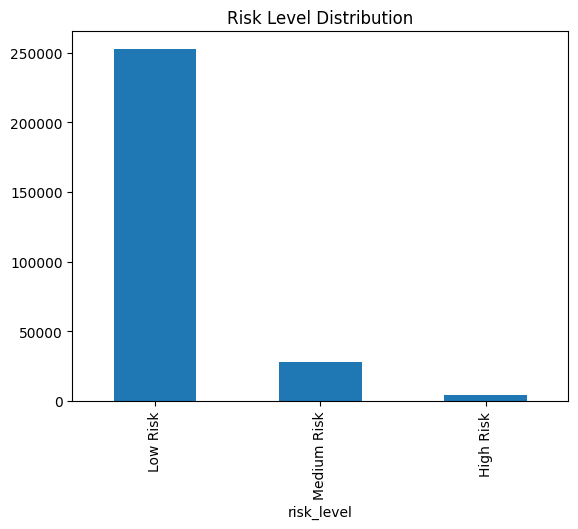

In [7]:
import matplotlib.pyplot as plt

df['risk_level'].value_counts().plot(kind='bar')
plt.title("Risk Level Distribution")
plt.show()
